<a href="https://colab.research.google.com/github/FelipeTufaile/customer_lifetime_value/blob/main/notebooks/Feature_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [908 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,131 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,787 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,118 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,218 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,552 kB]
Hit:13 https://

'/usr/local/lib/python3.10/dist-packages/pyspark'

## Loading Libraries

In [ ]:
# Importing Numpy library
import numpy as np

# Importing Pandas library
import pandas as pd

# Importing datetime library
from datetime import datetime, timedelta

# Importing plotying libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType, TimestampType
import pyspark.sql.functions as f
from pyspark.sql.window import Window


# Creating a spark session
spark = SparkSession.builder.appName("FeatureAnalysis").getOrCreate()

spark

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


## Read Data

The following cell reads the customer lifetime value data from Google Drive and converts it to a pandas dataframe for feature analysis. For more details about how the customer lifetime value dataframe was created please see notebook https://github.com/FelipeTufaile/customer_lifetime_value/blob/main/notebooks/Customer_Spend_Model_Feature_Processing.ipynb.

In [ ]:
# Defining dataframe path
file_path = "../content/drive/MyDrive/Colab/Sandbox/customer_spend_model"

# Reading customer lifetime value dataframe and creating a pandas table
cltv_tbl = spark.read.parquet(file_path).toPandas()

# Showing the dataframe
cltv_tbl

,cust_id,ref_dt,ref_year,ref_month,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3,trans_amt_R03m_lead1
0,4215567,2012-06-01,2012,6,18.687706,4.555068,5.687671,10,262.292671,45.550685,0,1,0,1,0.000000,24.899910,0.00000,15.236496,0.000000
1,4215567,2012-07-01,2012,7,18.687706,4.655342,6.706849,10,262.292671,46.553425,0,0,1,1,0.000000,0.000000,24.89991,15.236496,0.000000
2,4215567,2012-08-01,2012,8,18.687706,4.757260,7.726027,10,262.292671,47.572603,0,0,1,1,0.000000,0.000000,24.89991,15.236496,0.000000
3,4215567,2012-09-01,2012,9,18.687706,4.857534,8.712329,10,262.292671,48.575342,0,0,1,0,0.000000,0.000000,24.89991,0.000000,0.000000
4,4215567,2012-10-01,2012,10,18.687706,4.957808,9.731507,10,262.292671,49.578082,0,0,0,1,0.000000,0.000000,0.00000,24.899910,15.899994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749984,14764644,2013-08-01,2013,8,103.650154,0.049315,0.098630,1,103.650154,0.049315,1,0,0,0,103.650154,0.000000,0.00000,0.000000,0.000000
749985,14764644,2013-09-01,2013,9,103.650154,0.608219,1.084932,1,103.650154,0.608219,1,0,0,0,103.650154,0.000000,0.00000,0.000000,0.000000
749986,14764644,2013-10-01,2013,10,103.650154,1.610959,2.104110,1,103.650154,1.610959,1,0,0,0,103.650154,0.000000,0.00000,0.000000,0.000000
749987,14764644,2013-11-01,2013,11,103.650154,2.613699,3.090411,1,103.650154,2.613699,0,1,0,0,0.000000,103.650154,0.00000,0.000000,0.000000


## Features Description

All information is aggregated at a customer level and month level.

- **cust_id**: Customer id;
- **ref_dt**: The reference date used in calculations that are time dependent like recency and account age (the date format is *MS* - Month Start);
- **ref_year**: The year corresponding to the **ref_dt**;
- **ref_month**: The month (number) corresponding to the **ref_dt**;
- **first_trans_amt**: First transaction amount;
- **cycle_length**: The number of months between subsequent transactions;
- **recency**: Number of days between the reference date and the last transaction date;
- **frequency**: Number of months with transactions up to the reference date;
- **monetary**: Total amount spent up to the reference date;
- **lifetime**: Number of days between the reference date and the first transaction date;
- **tran_qnt_R03m_lag0**: The rolling 3 months transaction quantity. This feature will be set to zero when there is not enough transaction history to calculate it;
- **tran_qnt_R03m_lag1**: The rolling 3 months transaction quantity lagged by 3 months. This feature will be set to zero when there is not enough transaction history to calculate it;
- **tran_qnt_R03m_lag2**: The rolling 3 months transaction quantity lagged by 6 months. This feature will be set to zero when there is not enough transaction history to calculate it;
- **tran_qnt_R03m_lag3**: The rolling 3 months transaction quantity lagged by 9 months. This feature will be set to zero when there is not enough transaction history to calculate it;
- **tran_amt_R03m_lag0**: The rolling 3 months transaction amount. This feature will be set to zero when there is not enough transaction history to calculate it;
- **tran_amt_R03m_lag1**: The rolling 3 months transaction amount lagged by 3 months. This feature will be set to zero when there is not enough transaction history to calculate it;
- **tran_amt_R03m_lag2**: The rolling 3 months transaction amount lagged by 6 months. This feature will be set to zero when there is not enough transaction history to calculate it;t;
- **tran_amt_R03m_lag3**: The rolling 3 months transaction amount lagged by 9 months. This feature will be set to zero when there is not enough transaction history to calculate it;
- **tran_amt_R03m_lead1**: The rolling 3 months transaction amount over the next 3 months. **Note**: Caution should be taken when using this feature as target. Since this feature measures the transaction amount over the next 3 months, the last reference date we can use in order to have a valid calculation for this feature is 01 Jul 2014 - considering that we don't have information for the whole month of Nov 2014.

In [ ]:
# Listing features
# The following are the features to be used in the customer lifetime value model
features = [
  'first_trans_amt',
  'cycle_length',
  'recency',
  'frequency',
  'monetary',
  'lifetime',
  'trans_qnt_R03m_lag0',
  'trans_qnt_R03m_lag1',
  'trans_qnt_R03m_lag2',
  'trans_qnt_R03m_lag3',
  'trans_amt_R03m_lag0',
  'trans_amt_R03m_lag1',
  'trans_amt_R03m_lag2',
  'trans_amt_R03m_lag3'
]

# Description
cltv_tbl[features].describe()

,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3
count,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000
mean,45.074471,9.916011,12.352858,4.649366,207.385404,30.558343,0.364296,0.347498,0.330657,0.312954,16.062279,15.336601,14.628201,13.918000
std,80.573522,10.422862,13.527932,4.934415,385.286430,21.962422,0.612799,0.604030,0.594226,0.582729,53.753029,52.933437,52.162775,51.122268
min,1.950000,0.000000,0.000000,1.000000,1.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.150269,3.646027,3.024658,1.000000,48.599976,11.506849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.827915,6.591781,7.200000,3.000000,108.623924,26.843836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,53.583370,12.016438,16.471233,6.000000,235.629734,46.882192,1.000000,1.000000,1.000000,1.000000,15.899994,14.399994,10.200272,7.669376
max,5547.515625,84.345205,84.723288,72.000000,26887.071605,84.345205,3.000000,3.000000,3.000000,3.000000,9412.396847,9412.396847,9412.396847,9412.396847


## Features Distribution

If we plot the distribution of each feature listed above, we observe that most of the features exhibit an exponential distribution. For features derived from rolling calculations, we also notice a significant frequency of zero values. This is partly due to instances where insufficient transaction history exists to compute the rolling calculations.

In [ ]:
# Defining cutoff for the trans_amt_R03m_lead1:
# A limit ref_dt that should be set when using trans_amt_R03m_lead1 as the target as explained before.
cutoff = (cltv_tbl.ref_dt.max() - timedelta(days=93)).replace(day=1).strftime("%Y-%m-%d")
print(f"The cutoff date to use trans_amt_R03m_lead1 as target is: {cutoff}")

The cutoff date to use trans_amt_R03m_lead1 as target is: 2014-07-01


### Distribution of Features Related to Transaction Amount

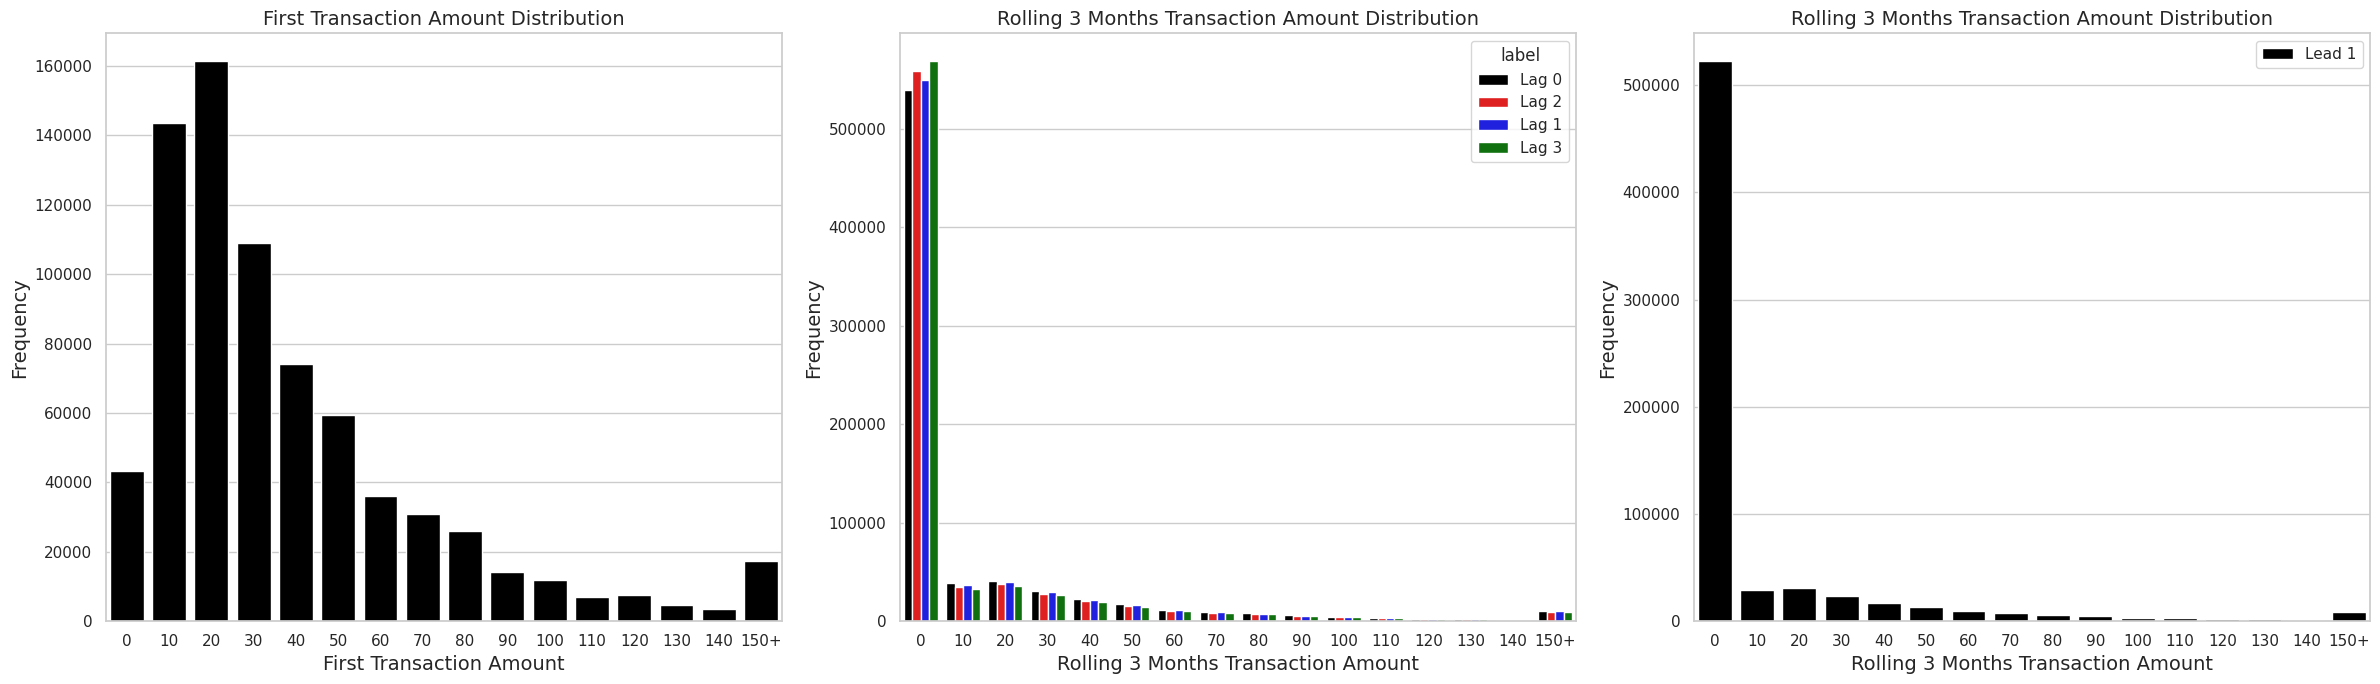

In [ ]:
# Set the figure size
plt.figure(figsize=(24, 7))

###################################################################################
plt.subplot(131)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.first_trans_amt/10)*10)
        .assign(bin = lambda x:[int(value) if value < 150 else 150 for value in x.bin])
        .assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin', 'bin_label'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin_label",
    y="counter",
    color="black"
)
plt.xlabel('First Transaction Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('First Transaction Amount Distribution', fontsize=14)

###################################################################################
plt.subplot(132)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        pd.concat(
            [
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag0.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 0"),
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag1.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 1"),
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag2.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 2"),
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag3.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 3"),
            ], axis=0
        )
        .assign(bin = lambda x:[np.floor(value/10)*10 if value >= 0 else -1 for value in x.trans_amt_R03m])
        .assign(bin = lambda x:[int(value) if value < 150 else 150 for value in x.bin])
        .assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['label', 'bin', 'bin_label'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin_label",
    y="counter",
    hue="label",
    palette=["black", "red", "blue", "green"]
)
plt.xlabel('Rolling 3 Months Transaction Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Rolling 3 Months Transaction Amount Distribution', fontsize=14)

###################################################################################
plt.subplot(133)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl[pd.to_datetime(cltv_tbl.ref_dt) <= cutoff]
        .assign(bin = lambda x:np.floor(x.trans_amt_R03m_lead1/10)*10)
        .assign(bin = lambda x:[int(value) if value < 150 else 150 for value in x.bin])
        .assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin', 'bin_label'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin_label",
    y="counter",
    color="black",
    label="Lead 1"
)
plt.xlabel('Rolling 3 Months Transaction Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Rolling 3 Months Transaction Amount Distribution', fontsize=14)

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

### Distribution of Features Related to Transaction Quantity

Although we see that the rolling quantities seems to follow an exponential distribution, there is only 4 possible values for each one of these features ranging from 0 to 3. Therefore, since the difference in magnitude between the possible values for the rolling quantities are small we are not going to transform these feature with a \\(log(x+1)\\) transformation.

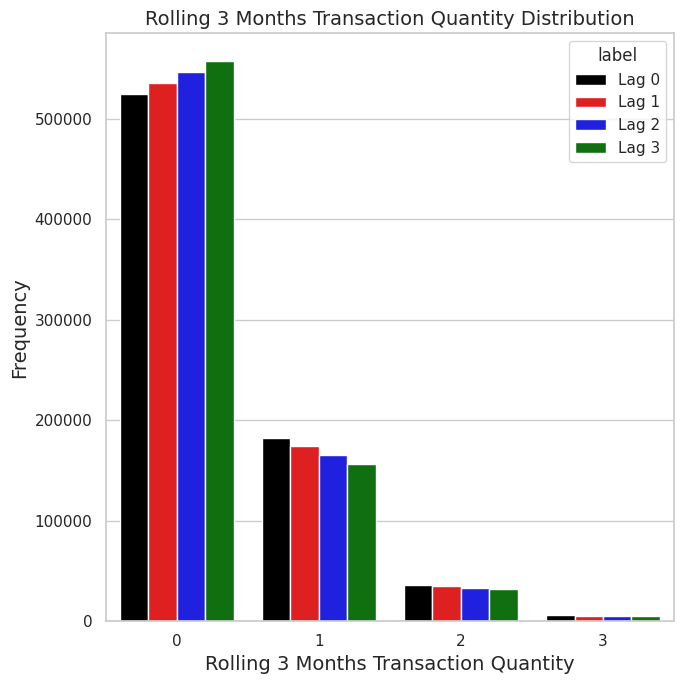

In [ ]:
# Set the figure size
plt.figure(figsize=(7, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        pd.concat(
            [
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag0.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 0"),
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag1.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 1"),
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag2.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 2"),
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag3.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 3"),
            ], axis=0
        )
        .assign(bin = lambda x:x.trans_qnt_R03m)
        .assign(counter = lambda x:1)
        .groupby(['label', 'bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    hue="label",
    palette=["black", "red", "blue", "green"]
)
plt.xlabel('Rolling 3 Months Transaction Quantity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Rolling 3 Months Transaction Quantity Distribution', fontsize=14)


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

### Distribution of RFML features

Looking at the RFML features' distribution, we note that the *lifetime* feature has the most unique distribution compared to other features. That is, the distribution doesn't seem to exponentially deacreses for higher lifetime values. Instead it seems to linearly decrease.

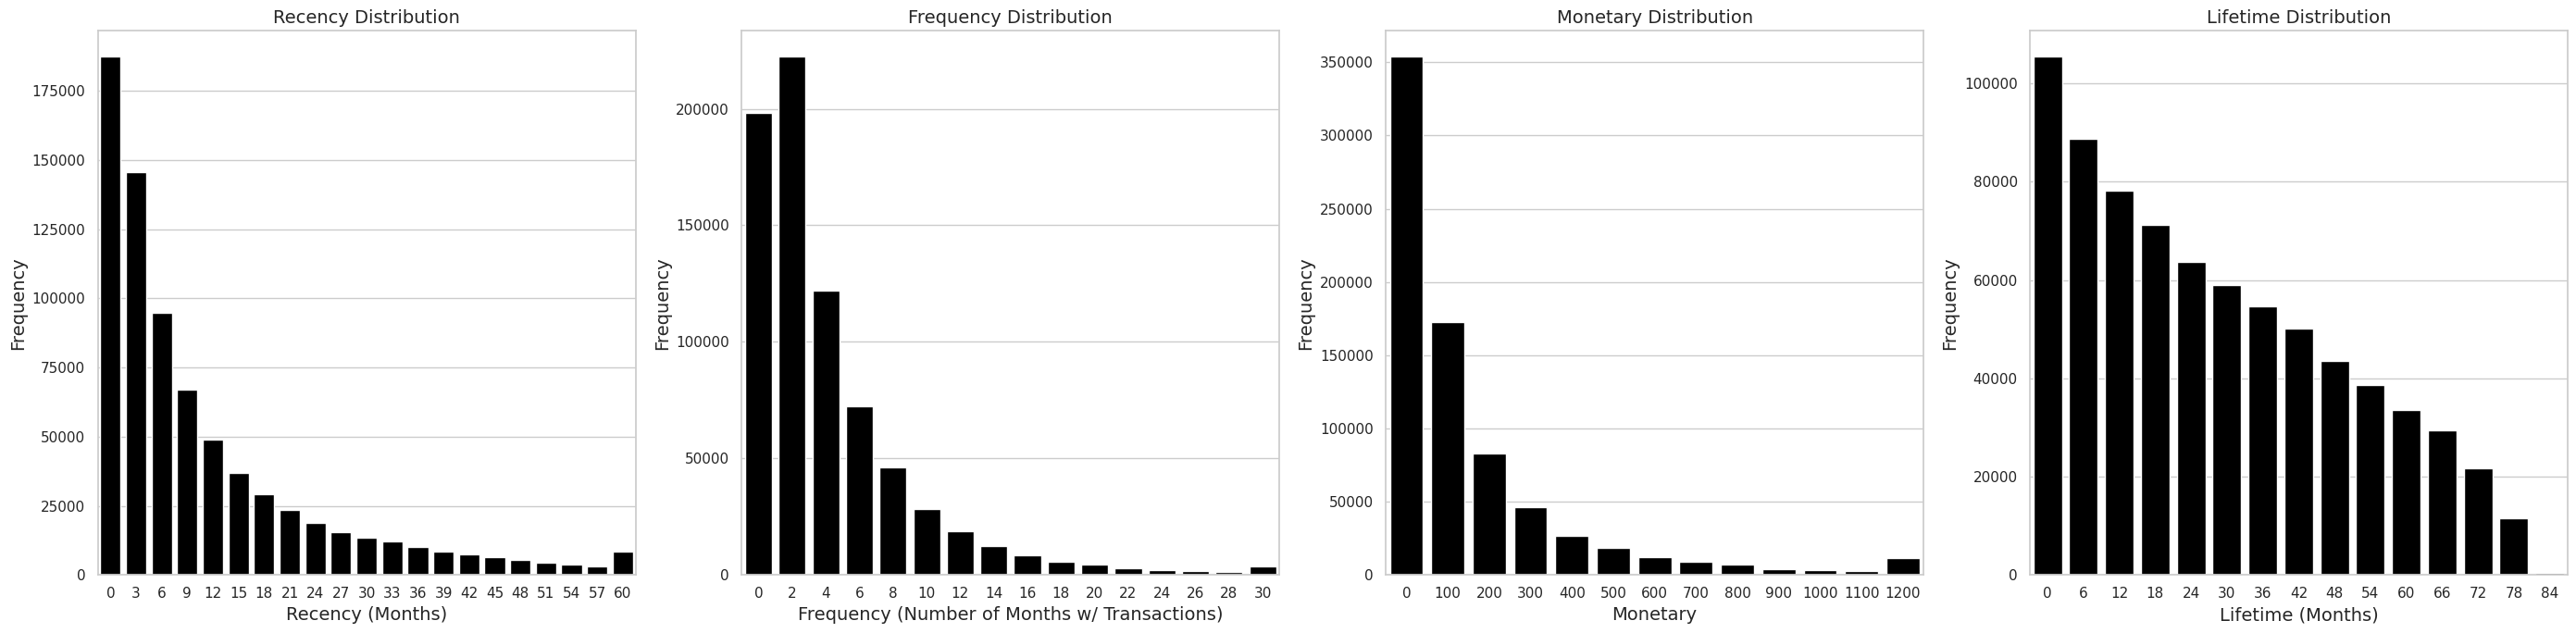

In [ ]:
# Set the figure size
plt.figure(figsize=(28, 7))

###################################################################################
plt.subplot(141)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.recency/3)*3)
        .assign(bin = lambda x:[int(value) if value < 60 else 60 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Recency (Months)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Recency Distribution', fontsize=14)

###################################################################################
plt.subplot(142)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.frequency/2)*2)
        .assign(bin = lambda x:[int(value) if value < 30 else 30 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Frequency (Number of Months w/ Transactions)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Frequency Distribution', fontsize=14)

###################################################################################
plt.subplot(143)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.monetary/100)*100)
        .assign(bin = lambda x:[int(value) if value < 1200 else 1200 for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Monetary', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Monetary Distribution', fontsize=14)


###################################################################################
plt.subplot(144)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.lifetime/6)*6)
        .assign(bin = lambda x:[int(value) if value < 84 else 84 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Lifetime (Months)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Lifetime Distribution', fontsize=14)


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

### Cycle Length

Similarly to most of the features, *cycle length* exhibits a exponential distribution. It is noticeable that the *cycle length* distribution is concentrated around 3 months. This suggests that, in general, most customer purchase every 3 months. This is also the reason why we have chosen to predict the purchase for the next 3 months: we expected a significative percentage of the customers to have made a subsequent purchase in a period of 3 months.

Ideally, we would like to apply the same transformation we applied to *recency* to *cycle length*. This is because we can make the values of these two features, after the transformation, comparable: we would expect that when *recency* approaches to *cycle length* the likelihood of a subsequent purchase increases.

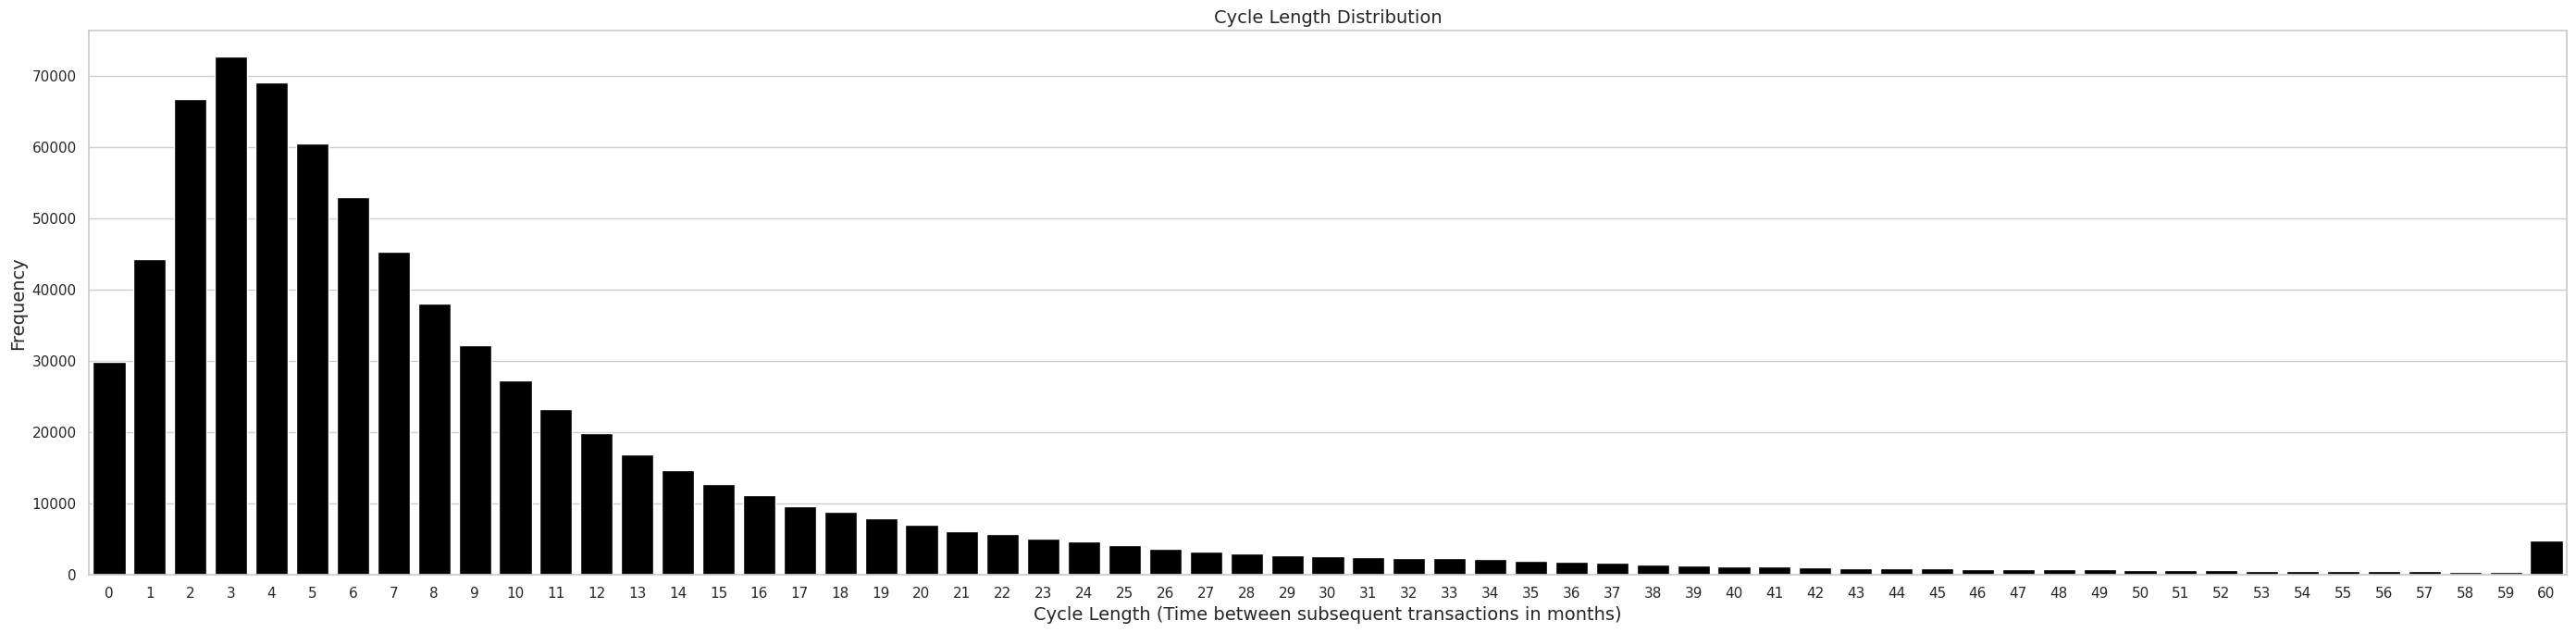

In [ ]:
# Set the figure size
plt.figure(figsize=(28, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.cycle_length/1)*1)
        .assign(bin = lambda x:[int(value) if value < 60 else 60 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Cycle Length (Time between subsequent transactions in months)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Cycle Length Distribution', fontsize=14)

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

The following visualization shows the cumulative percentage of the *cycle length* feature.

In the left figure we considered all customers. We note that for 28.5% of the customers the time between subsequent purchases is less than or equal to 3 months.

In the right figure we considered only customer with more than one purchase. We note that a slightly smaller percentage of the customers have a subsequent purchase in less than 3 months (27.7%). This makes sense since when we set frequency to be higher than one we endup excluding new customers, includind those that have less than 3 months of lifetime. This decreases the number of customers with cycle length lower than 3 months.

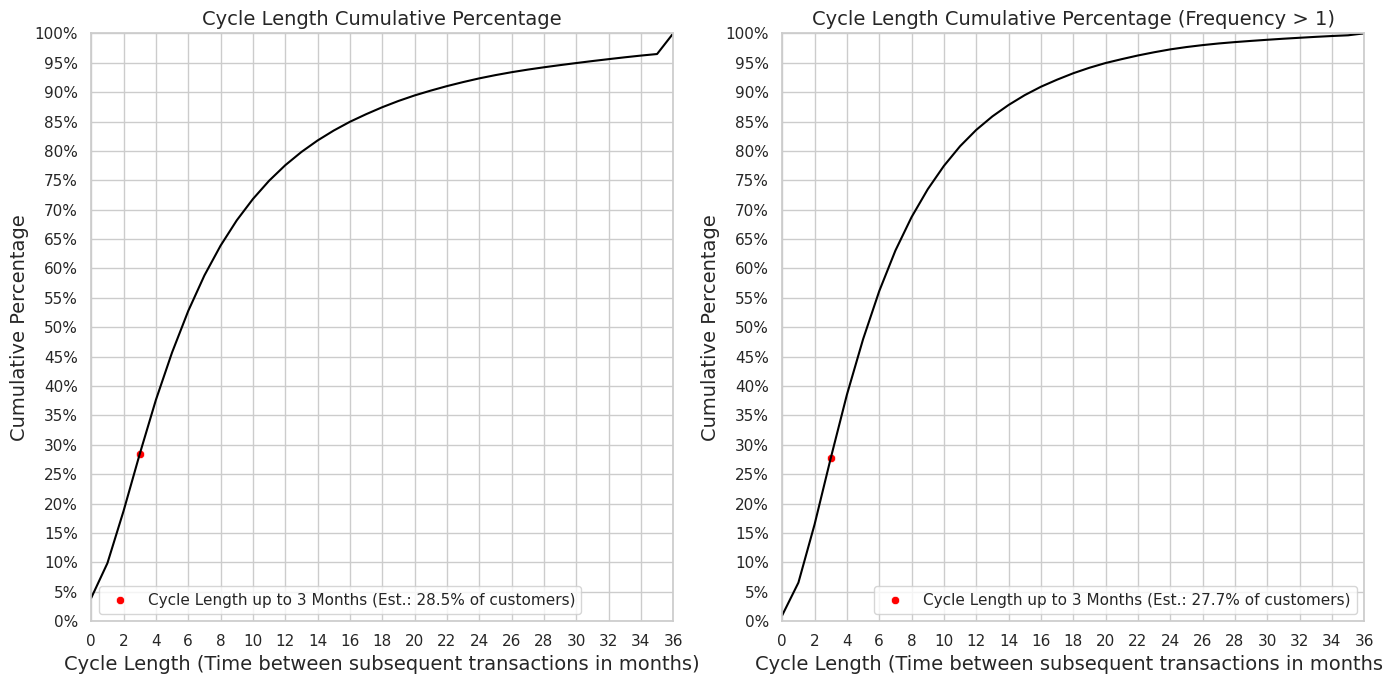

In [ ]:
# Set the figure size
plt.figure(figsize=(14, 7))

# Creating a dataframe with aggregated statistics on cycle length
cycle_length_tbl = (
  cltv_tbl
  .assign(bin = lambda x:np.floor(x.cycle_length/1)*1)
  .assign(bin = lambda x:[int(value) if value < 36 else 36 for value in x.bin])
  .assign(counter = lambda x:1)
  .groupby(['bin'])
  .agg({'counter':'sum'})
  .reset_index()
  .sort_values(by="bin")
  .assign(cumulative_percentage = lambda x:x.counter.cumsum()/x.counter.sum())
)

# Calculating the percentage of customers that have a cycle length of 3 months
pctg_trans_3m = cycle_length_tbl[cycle_length_tbl.bin==3].cumulative_percentage.values[0]

###################################################################################
plt.subplot(121)
sns.set(style="whitegrid")
sns.lineplot(data=cycle_length_tbl, x="bin", y="cumulative_percentage", color="black")
sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Cycle Length (Time between subsequent transactions in months)', fontsize=14)
plt.ylabel('Cumulative Percentage', fontsize=14)
plt.title('Cycle Length Cumulative Percentage', fontsize=14)

plt.xlim([0, 36])
plt.xticks(ticks=[0 + i*2 for i in range(19)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Creating a dataframe with aggregated statistics on cycle length
cycle_length_tbl = (
  cltv_tbl[cltv_tbl.frequency > 1]
  .assign(bin = lambda x:np.floor(x.cycle_length/1)*1)
  .assign(bin = lambda x:[int(value) if value < 36 else 36 for value in x.bin])
  .assign(counter = lambda x:1)
  .groupby(['bin'])
  .agg({'counter':'sum'})
  .reset_index()
  .sort_values(by="bin")
  .assign(cumulative_percentage = lambda x:x.counter.cumsum()/x.counter.sum())
)

# Calculating the percentage of customers that have a cycle length of 3 months
pctg_trans_3m = cycle_length_tbl[cycle_length_tbl.bin==3].cumulative_percentage.values[0]

###################################################################################
plt.subplot(122)
sns.set(style="whitegrid")
sns.lineplot(data=cycle_length_tbl, x="bin", y="cumulative_percentage", color="black")
sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Cycle Length (Time between subsequent transactions in months)', fontsize=14)
plt.ylabel('Cumulative Percentage', fontsize=14)
plt.title('Cycle Length Cumulative Percentage (Frequency > 1)', fontsize=14)

plt.xlim([0, 36])
plt.xticks(ticks=[0 + i*2 for i in range(19)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

The following visualizations show the percentage of customers (with frequency > 1) that have a subsequent purchase in less than 3 months. We note that this percentage decreases sharply in the beginning of the series (when the number of distinct customer ids is small) and tends to decrease at a slower pace by the end of the series (when the number of distinct customer ids is much larger). This suggests that a *steady state* percentage of customer with a cycle length of 3 months or lower should be around 20% when the customer database is mature enough.  

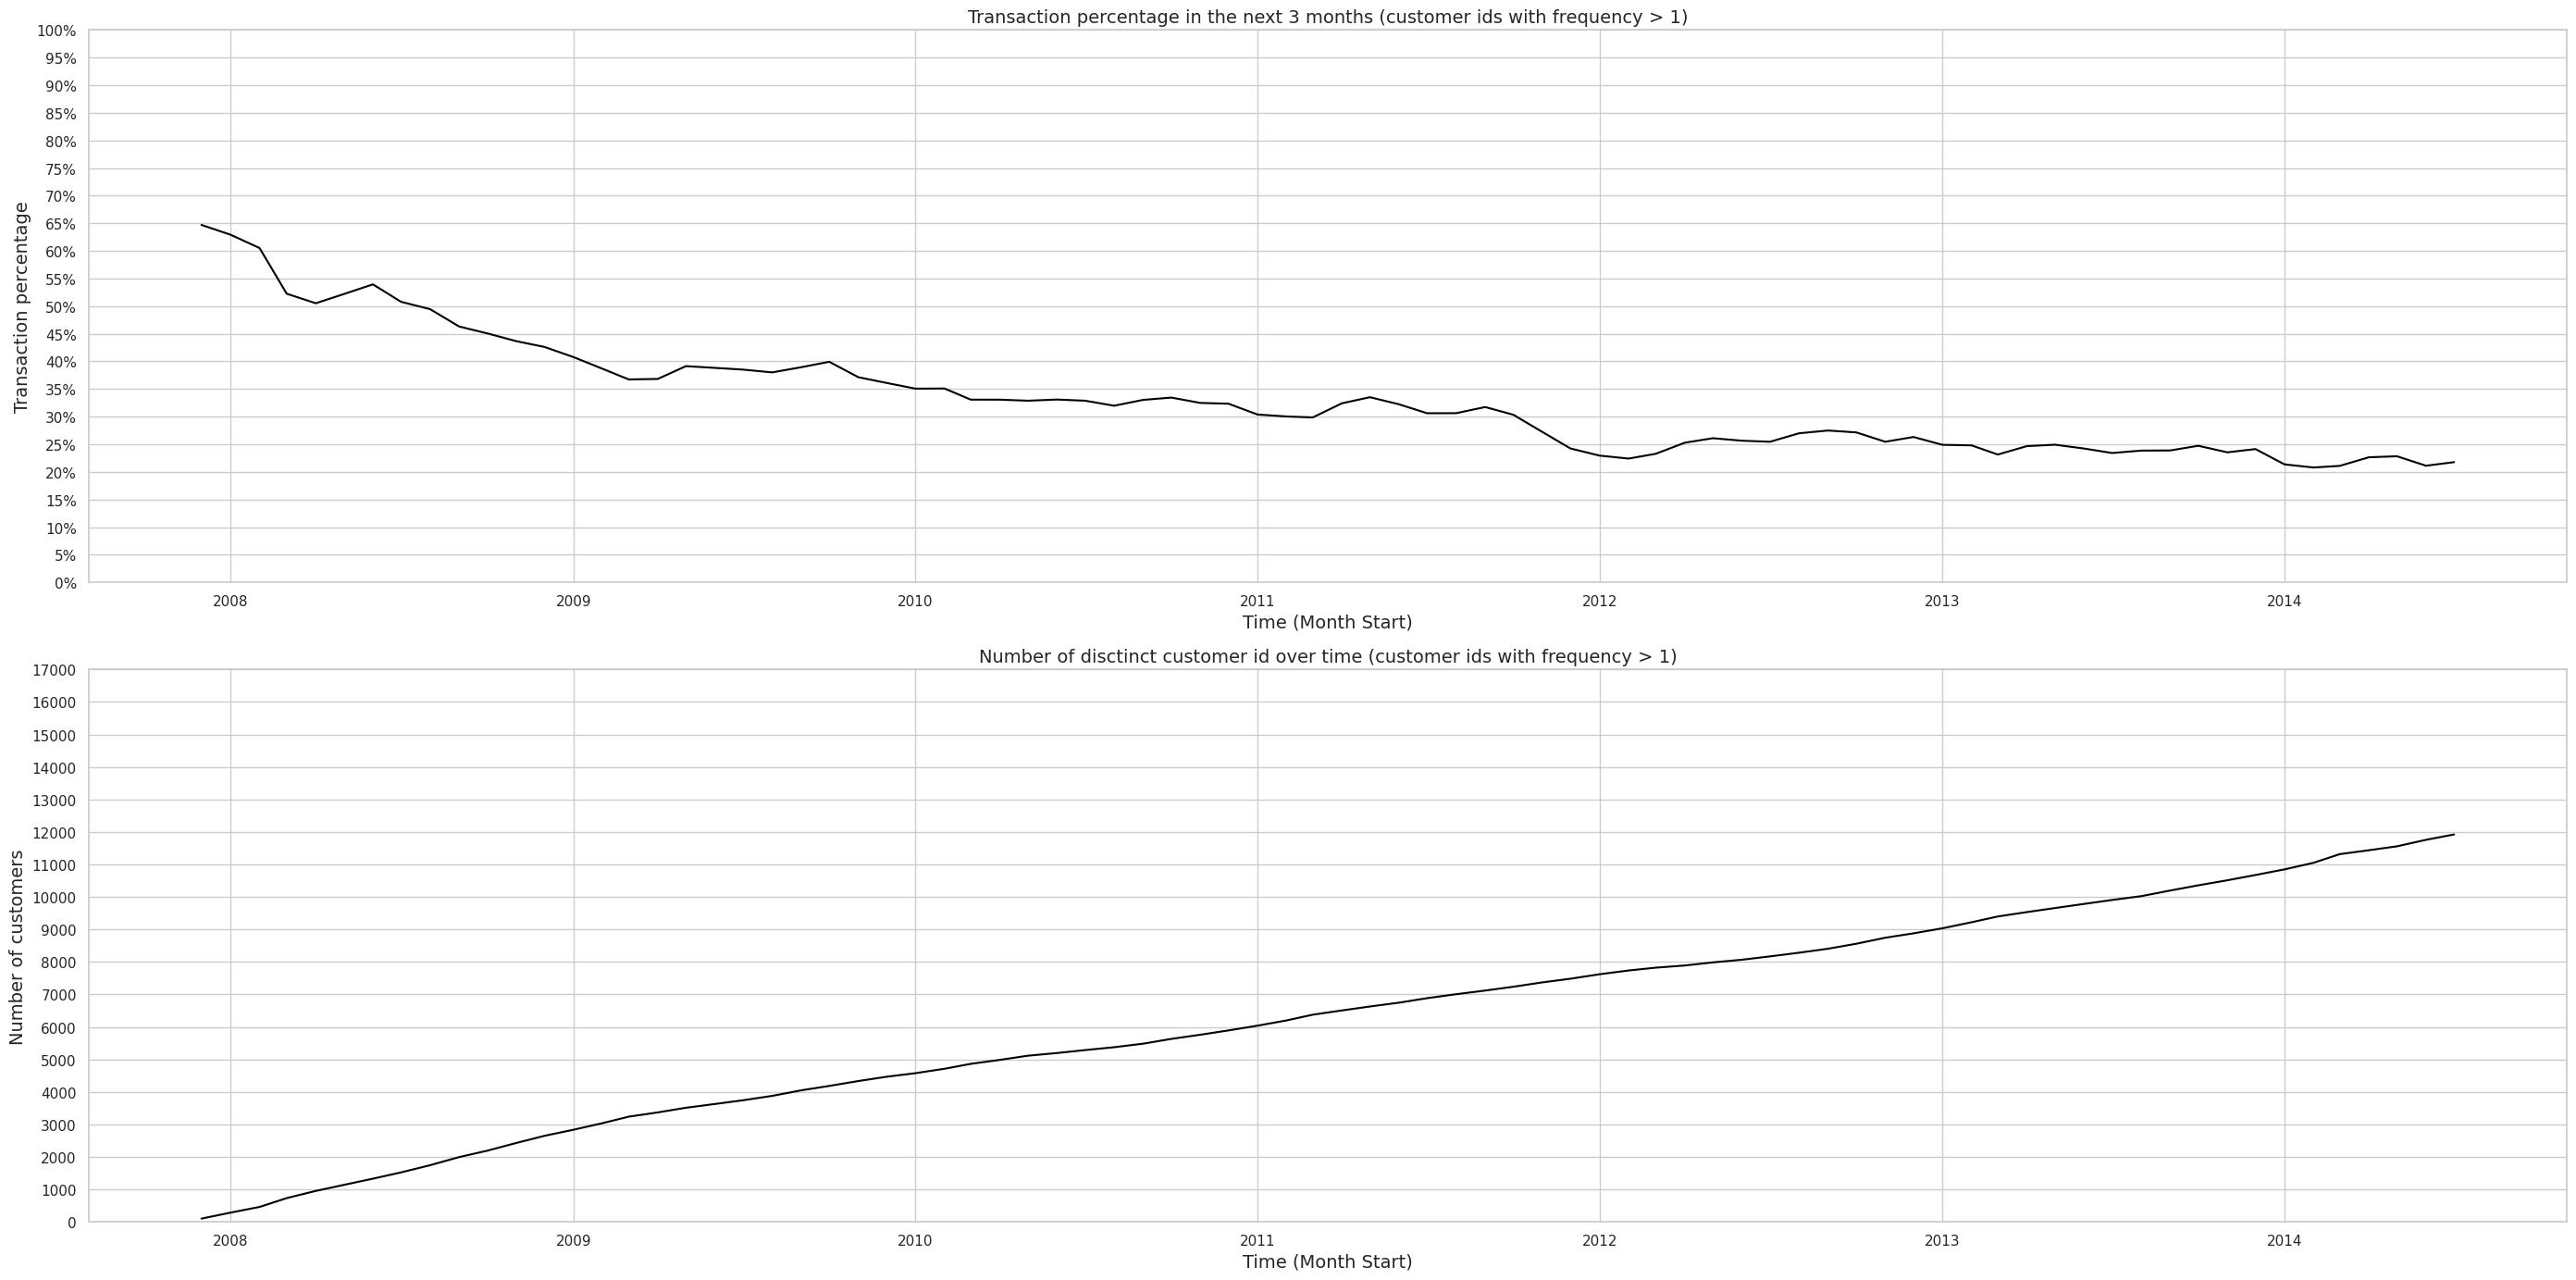

In [ ]:
# Creating a transaction percentage in the next 3 months dataframe
trans_next_3m_tbl = (
    cltv_tbl[(pd.to_datetime(cltv_tbl.ref_dt) <= cutoff) & (cltv_tbl.frequency > 1)]
    .assign(trans_next_3m = lambda x:np.where(x.trans_amt_R03m_lead1 > 0, 1, 0))
    .groupby(['ref_dt'])
    .agg({"trans_next_3m":"mean", "cust_id": lambda x: x.nunique()})
    .reset_index()
    .sort_values(by="ref_dt", ascending=True)

)


# Set the figure size
plt.figure(figsize=(28, 14))

###################################################################################
plt.subplot(211)
sns.set(style="whitegrid")
sns.lineplot(data=trans_next_3m_tbl, x="ref_dt", y="trans_next_3m", color="black")
#sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Time (Month Start)', fontsize=14)
plt.ylabel('Transaction percentage', fontsize=14)
plt.title('Transaction percentage in the next 3 months (customer ids with frequency > 1)', fontsize=14)

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

###################################################################################
plt.subplot(212)
sns.set(style="whitegrid")
sns.lineplot(data=trans_next_3m_tbl, x="ref_dt", y="cust_id", color="black")
#sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Time (Month Start)', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Number of disctinct customer id over time (customer ids with frequency > 1)', fontsize=14)

plt.ylim([0, 17000])
plt.yticks(ticks=[0 + i*1000 for i in range(18)])


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

## Feature Adjustments

To address these issues and transform the features to have a distribution centered around a mean value (closer to a normal distribution), we can apply the following transformation:

$$
f(x) = \log(x + 1)
$$


The reason we sum 1 to *x* inside of the \\(log\\) is to avoid \\(log(0)\\) which is not defined mathematically.

Specfically for the **lifetime** feature, since is the distribution of its values suggests that the frequency decreases linearly with the increase of lifetime value we will also attempt to transform this feature using **percentile rank**. With percentile rank the original lifeitme value is replaced by its percentile rank which is a number between 0 and 1. This way we reduce the magnitude of the lifetime values which speeds up the training process.

In order to calculate the percentile rank, it will be used the *dense* method. This method assign the same rank to equal lifetime values and also increase the rank counting according to the lifetime values levels only. That is, it doesn't take into consideration the number of records with the same lifetime value when calculating the next rank value.

Finally, it was decided to remove 1 unit from the rank outputed by the *rank* function so the rank ordering starts at 0 instead of 1. This way, we ensure that lifetime value equal to 0 has a percentile rank of zero.

In [ ]:
# Calculating lifetime rank
lifetime_rank = cltv_tbl.lifetime.rank(method="dense").values - 1

# Calculating maximum lifetime rank
max_rank = np.max(lifetime_rank)

# Customer lifetime value table adjusted
cltv_tbl_adj_tbl = (

  # Referencing the customer lifetime value table
  cltv_tbl

  # Calculating the log(x+1) of the cycle length
  .assign(cycle_length = lambda x:np.log(x.cycle_length + 1))

  # Calculating the log(x+1) of the recency
  .assign(recency = lambda x:np.log(x.recency + 1))

  # Calculating the log(x+1) of the frequency
  .assign(frequency = lambda x:np.log(x.frequency + 1))

  # Calculating the log(x+1) of the monetary
  .assign(monetary = lambda x:np.log(x.monetary + 1))

  # Calculating the percentile rank of the lifetime
  .assign(lifetime = lambda x:lifetime_rank/max_rank)

  # Calculating the log(x+1) of the first_trans_amt
  .assign(first_trans_amt = lambda x:np.log(x.first_trans_amt + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag0
  .assign(trans_amt_R03m_lag0 = lambda x:np.log(x.trans_amt_R03m_lag0 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag1
  .assign(trans_amt_R03m_lag1 = lambda x:np.log(x.trans_amt_R03m_lag1 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag2
  .assign(trans_amt_R03m_lag2 = lambda x:np.log(x.trans_amt_R03m_lag2 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag3
  .assign(trans_amt_R03m_lag3 = lambda x:np.log(x.trans_amt_R03m_lag3 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag3
  .assign(trans_amt_R03m_lead1 = lambda x:np.log(x.trans_amt_R03m_lead1 + 1))

)

cltv_tbl_adj_tbl[features + ['trans_amt_R03m_lead1']].describe()

,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3,trans_amt_R03m_lead1
count,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000
mean,3.519177,2.063764,2.148899,1.474129,4.691031,0.368069,0.364296,0.347498,0.330657,0.312954,1.088831,1.038457,0.988757,0.937357,0.866771
std,0.743765,0.794574,0.946980,0.677535,1.130644,0.264463,0.612799,0.604030,0.594226,0.582729,1.721942,1.697967,1.672600,1.644673,1.602075
min,1.081805,0.000000,0.000000,0.693147,1.081805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.051653,1.536013,1.392440,0.693147,3.903990,0.138614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.491279,2.027066,2.104134,1.386294,4.697056,0.323366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.999729,2.566213,2.860556,1.945910,5.466497,0.564752,1.000000,1.000000,1.000000,1.000000,2.827313,2.734367,2.415938,2.159797,0.000000
max,8.621286,4.446704,4.451125,4.290459,10.199438,1.000000,3.000000,3.000000,3.000000,3.000000,9.149889,9.149889,9.149889,9.149889,9.149889


### Distribution of Features Related to Transaction Amount after Feature Transformation

The first three visualizations in the sequence show the distribution of all features related to transaction amount after the log transformation. We note a  high frequency for \\(log(x+1) = 0\\) which is associated with no purchase in the rolling window calculated or a lack of transaction history. The exception if for the *first_trans_amt* feature since this feature is greater than zero, necessarily, for all customers.

The second visual in the sequence also show the distribution of all features related to transaction amount after the log transformation. However, this visual only considers \\(log(x+1) > 0\\). We can see that by removing \\(log(x+1) = 0\\) the resulting distribution seems to be closer to a normal distribution as we would expect.

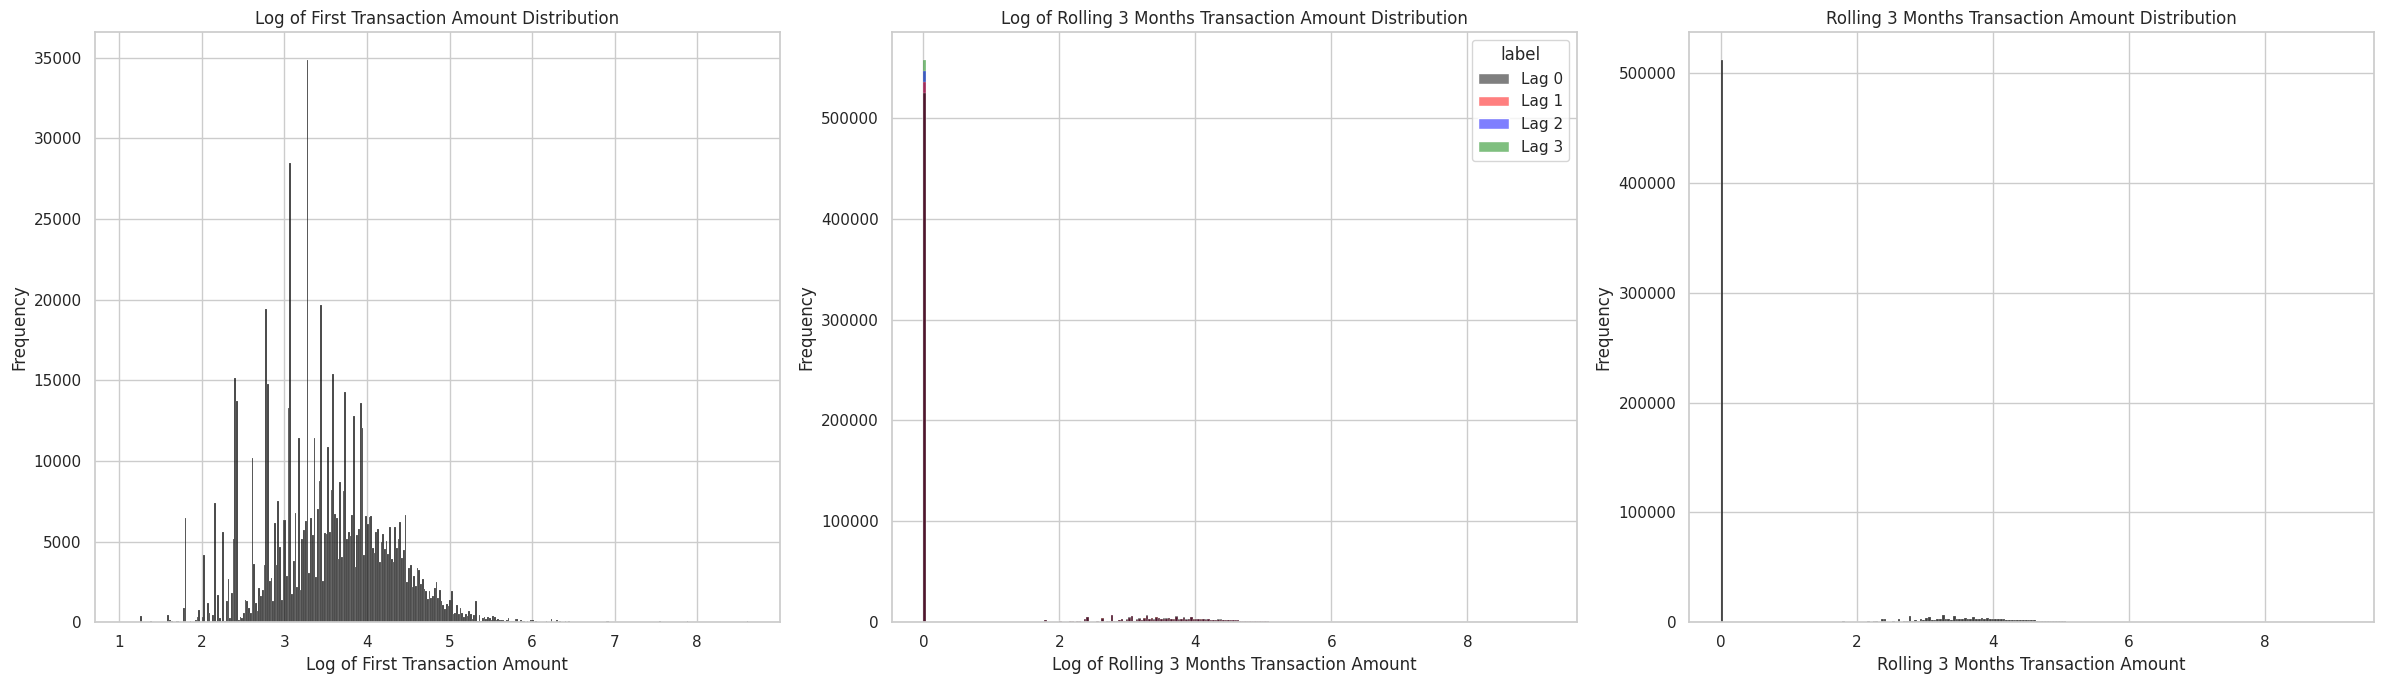

In [ ]:
# Set the figure size
plt.figure(figsize=(24, 7))

###################################################################################
plt.subplot(131)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="first_trans_amt", color="black")
plt.xlabel('Log of First Transaction Amount')
plt.ylabel('Frequency')
plt.title('Log of First Transaction Amount Distribution')

###################################################################################
plt.subplot(132)
sns.set(style="whitegrid")
sns.histplot(
    data=(
        pd.concat(
            [
              pd.DataFrame(cltv_tbl_adj_tbl.trans_amt_R03m_lag0.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 0"),
              pd.DataFrame(cltv_tbl_adj_tbl.trans_amt_R03m_lag1.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 1"),
              pd.DataFrame(cltv_tbl_adj_tbl.trans_amt_R03m_lag2.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 2"),
              pd.DataFrame(cltv_tbl_adj_tbl.trans_amt_R03m_lag3.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 3"),
            ], axis=0
        )
    ),
    x="trans_amt_R03m",
    hue="label",
    palette=["black", "red", "blue", "green"]
)
plt.xlabel('Log of Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Log of Rolling 3 Months Transaction Amount Distribution')

###################################################################################
plt.subplot(133)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl[pd.to_datetime(cltv_tbl_adj_tbl.ref_dt) <= cutoff], x="trans_amt_R03m_lead1", color="black", label="Lead 1")
plt.xlabel('Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Rolling 3 Months Transaction Amount Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

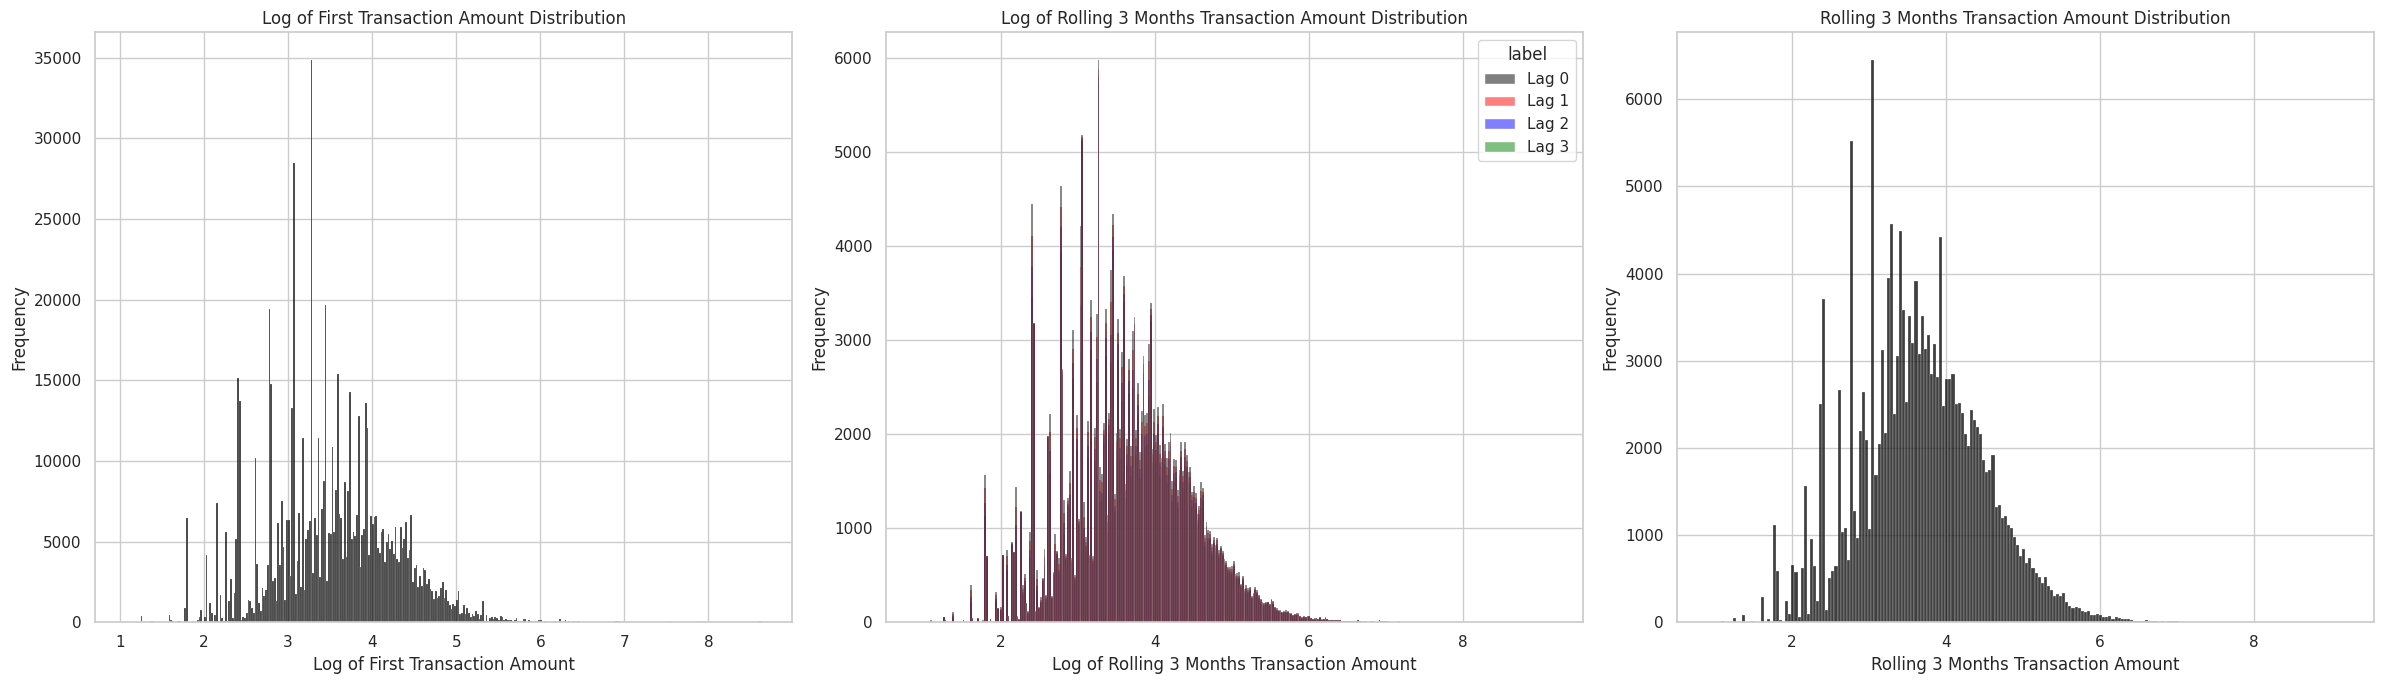

In [ ]:
# Set the figure size
plt.figure(figsize=(24, 7))

###################################################################################
plt.subplot(131)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="first_trans_amt", color="black")
plt.xlabel('Log of First Transaction Amount')
plt.ylabel('Frequency')
plt.title('Log of First Transaction Amount Distribution')

###################################################################################
plt.subplot(132)
sns.set(style="whitegrid")
sns.histplot(
    data=(
        pd.concat(
            [
              pd.DataFrame(cltv_tbl_adj_tbl[cltv_tbl_adj_tbl.trans_amt_R03m_lag0 > 0].trans_amt_R03m_lag0.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 0"),
              pd.DataFrame(cltv_tbl_adj_tbl[cltv_tbl_adj_tbl.trans_amt_R03m_lag1 > 0].trans_amt_R03m_lag1.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 1"),
              pd.DataFrame(cltv_tbl_adj_tbl[cltv_tbl_adj_tbl.trans_amt_R03m_lag2 > 0].trans_amt_R03m_lag2.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 2"),
              pd.DataFrame(cltv_tbl_adj_tbl[cltv_tbl_adj_tbl.trans_amt_R03m_lag3 > 0].trans_amt_R03m_lag3.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 3"),
            ], axis=0
        )
    ),
    x="trans_amt_R03m",
    hue="label",
    palette=["black", "red", "blue", "green"]
)
plt.xlabel('Log of Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Log of Rolling 3 Months Transaction Amount Distribution')

###################################################################################
plt.subplot(133)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl[(pd.to_datetime(cltv_tbl_adj_tbl.ref_dt) <= cutoff) & (cltv_tbl_adj_tbl.trans_amt_R03m_lead1 > 0)], x="trans_amt_R03m_lead1", color="black", label="Lead 1")
plt.xlabel('Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Rolling 3 Months Transaction Amount Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

### Distribution of RFML Features after Feature Transformation

After the log transformation, we note that *recency* and *monetary* endup with distributions that seem closer to a normal distribution. The exception is the *frequency* feature that still seems exponentially distributed even after the log transformation. Nevertheless, the range of *frequency* values is much smaller than the range prior to the transformation. Therefore, we don't apply a log transformation again to *frequency*.

As for the *lifetime* feature, we see that the distribution after the percentile rank transformation looks similar to the distribution before the transformation. However, we note that the range of values is much smaller after implementing percentile rank.

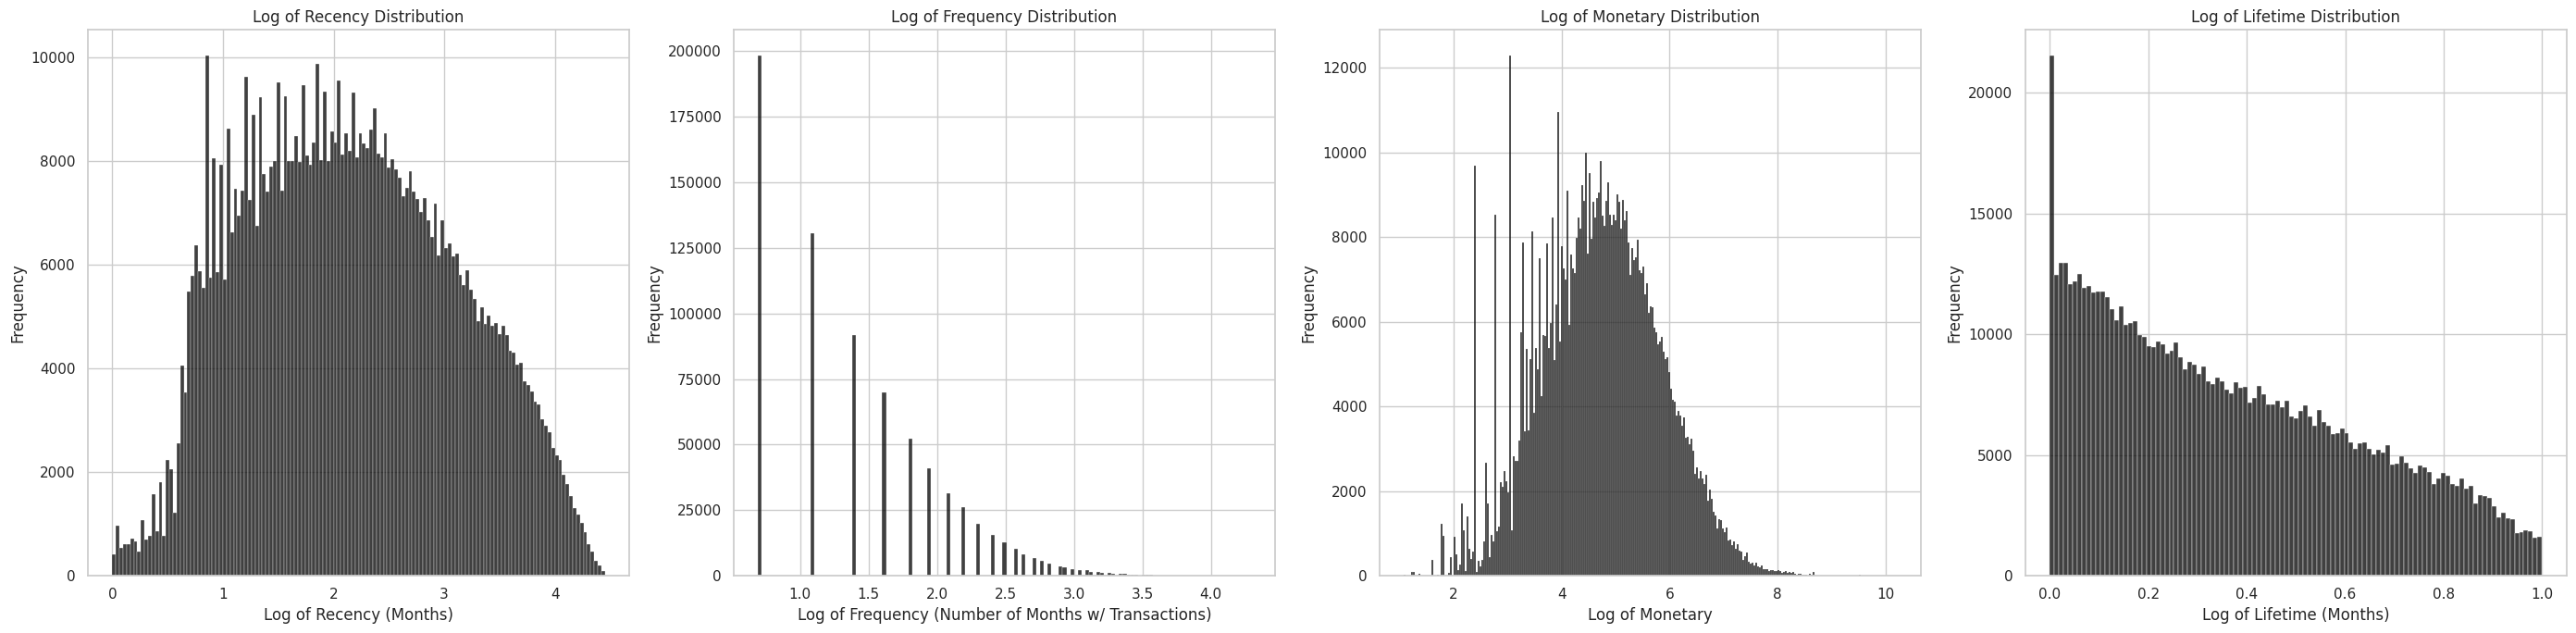

In [ ]:
# Set the figure size
plt.figure(figsize=(28, 7))

###################################################################################
plt.subplot(141)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="recency", color="black")
plt.xlabel('Log of Recency (Months)')
plt.ylabel('Frequency')
plt.title('Log of Recency Distribution')

###################################################################################
plt.subplot(142)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="frequency", color="black")
plt.xlabel('Log of Frequency (Number of Months w/ Transactions)')
plt.ylabel('Frequency')
plt.title('Log of Frequency Distribution')

###################################################################################
plt.subplot(143)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="monetary", color="black")
plt.xlabel('Log of Monetary')
plt.ylabel('Frequency')
plt.title('Log of Monetary Distribution')


###################################################################################
plt.subplot(144)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="lifetime", color="black")
plt.xlabel('Log of Lifetime (Months)')
plt.ylabel('Frequency')
plt.title('Log of Lifetime Distribution')


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

### Distribution of Cycle Length after Feature Transformation

Finally, the *cycle length* feature after the log transformation also seems to be closer to a normal distribution with values ranging from 0 to less than 5, a much smaller range.

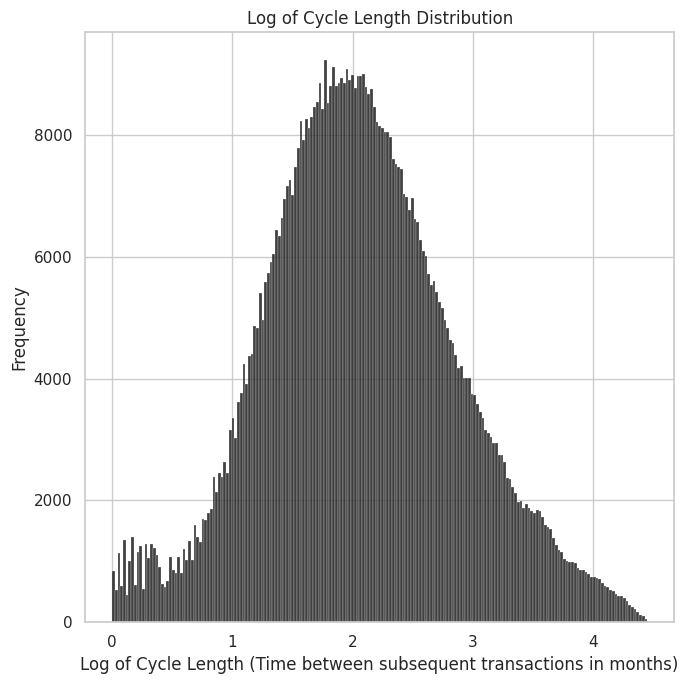

In [ ]:
# Set the figure size
plt.figure(figsize=(7, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.histplot(data=cltv_tbl_adj_tbl, x="cycle_length", color="black")
plt.xlabel('Log of Cycle Length (Time between subsequent transactions in months)')
plt.ylabel('Frequency')
plt.title('Log of Cycle Length Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()